In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
from math import floor

In [3]:
from PIL import Image,ImageFont,ImageDraw
import os
import imageio

In [4]:
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 144
plt.rcParams['axes.unicode_minus'] = False

In [5]:
edge_v = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])
                    
edge_h = np.array([[1, 1, 1],
                   [0, 0, 0],
                   [-1, -1, -1]])
 
edge_multi = np.array([[-1,-1,-1],
                       [-1,8,-1],
                       [-1,-1,-1]])

identity = np.array([[0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]])

sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])

blur_3 = np.array([[1, 2, 1],
                 [2, 4, 2],
                 [1, 2, 1]]) / 16

In [6]:
test_1 = np.array([[0, -1, 0],
                   [-1, 4, -1],
                   [0, -1, 0]])

In [7]:
def make_kernel(klist):
    k_l = np.array([])
    for k in klist:
        newk = np.array([k]*3)
        k_l = np.append(k_l, newk).reshape(-1, *newk.shape)
    return k_l

In [29]:
# kernel_list = make_kernel([edge_v, edge_h, edge_multi])
kernel_list = make_kernel([test_1] * 3)

In [32]:
kernel_list.shape

(3, 3, 3, 3)

In [10]:
img = Image.open("pic_1.jpg")
img_data = np.array(img).transpose((2, 0, 1))

In [12]:
def pad(data, width=1):
    m, n, r = data.shape
    res = np.zeros((m, n + 2 * width, r + 2 * width), 
                   dtype=data.dtype)
    res[:, width:-width, width:-width] = data
    return res

In [14]:
def get_piece(img, x, y, l):
    return img[:, x:x+l, y:y+l]

In [15]:
def conv(_data, kernel_list, padding=0, stride=1):
    print("conv with kernel size:{}\n\tpadding={}\n\tstride={}"
          .format(kernel_list.shape, padding, stride))
    print("Image size: {}".format(_data.shape))
    n_c, n_w, n_h = _data.shape
    assert kernel_list.shape[2] == kernel_list.shape[3]  # Square kernel is a must
    kernel_size = kernel_list.shape[2]
    assert n_c == kernel_list.shape[1] # #channels == #kernel_channels
    res_shape = kernel_list.shape[0], \
                floor((n_w + 2 * padding - kernel_size) / stride) + 1, \
                floor((n_h + 2 * padding - kernel_size) / stride) + 1
    res = np.zeros(res_shape)
    print("res shape:", res_shape)
    # return res
    if padding > 0:
        data = pad(_data, padding)
    else:
        data = _data.copy()
    dshape = data.shape # n_c, n_w, n_h  
    rx = 0
    ry = 0
    print("conv...")
    for k in range(kernel_list.shape[0]):
        rx = 0
        for x in np.arange(0, dshape[1] - kernel_size + 1, stride):
            ry = 0
            for y in np.arange(0, dshape[2] - kernel_size + 1, stride):
                # print(y)
                res[k, rx, ry] += np.dot(get_piece(data, x, y, kernel_size).flatten(),
                                          kernel_list[k].flatten())
                # print(k, rx, ry)
                ry += 1
            rx += 1
    print("conv complete!")
    return res

In [16]:
def max_pool(data):
    return data.max(axis=1).max(axis=1)

In [17]:
def avg_pool(data):
    return data.mean(axis=1).mean(axis=1)

In [18]:
def pool(_data, size=2, stride=2, padding=0, mode="max"):
#     print("Pooling with:\n\tsize = {}\n\tstride = {}\n\tpadding = {}\n\tmode={}"
#           .format(size, stride, padding, mode))
    if mode=="max":
        alg = max_pool
    elif mode == "avg":
        alg = avg_pool
    n_c, n_w, n_h = _data.shape
    res_shape = n_c, \
                floor((n_w + 2 * padding - size) / stride) + 1, \
                floor((n_h + 2 * padding - size) / stride) + 1
    res = np.zeros(res_shape)
    # print("res shape:", res_shape)
    if padding > 0:
        data = pad(_data, padding)
    else:
        data = _data.copy()
    dshape = data.shape
    rx = 0
    ry = 0
    for x in np.arange(0, dshape[1] - size + 1, stride):
        ry = 0
        for y in np.arange(0, dshape[2] - size + 1, stride):
            # print(y)
            res[:, rx, ry] = alg(data[:, x:x+size, y:y+size])
            ry += 1
        rx += 1
    return res

In [38]:
conv_res = conv(img_data, kernel_list, padding=1, stride=1)

conv with kernel size:(3, 3, 3, 3)
	padding=1
	stride=1
Image size: (3, 640, 640)
res shape: (3, 640, 640)
conv...
conv complete!


In [41]:
def show_img(data):
    print(data.shape)
    # data = np.transpose(_data, (1, 2, 0))
#     data = _data.sum(axis=0)
    plt.axis("off")
    return plt.imshow(data)

In [76]:
x = conv_res.transpose(1, 2, 0).astype(np.uint8)

In [77]:
x.dtype

dtype('uint8')

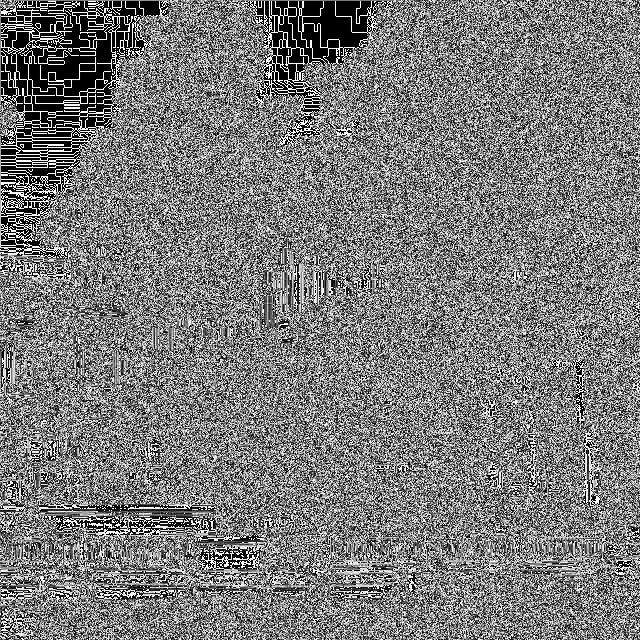

In [78]:
Image.fromarray(x)

In [21]:
for e in np.arange(1, 10, 0.5):
    size = floor(e**2)
    print(size, "...", end=" ")
    pool_res = pool(conv_res, mode="avg", padding=0, stride=size, size=size)
    show_img(pool_res)
    plt.savefig("pic/pool-{:02d}.jpg".format(size))
    plt.close()

1 ... 2 ... 4 ... 6 ... 9 ... 12 ... 16 ... 20 ... 25 ... 30 ... 36 ... 42 ... 49 ... 56 ... 64 ... 72 ... 81 ... 90 ... 

In [22]:
def make_gif(up):
    filelist = []  
    root = os.getcwd()
    pathr = os.path.join(root, up)
    files = os.listdir(pathr)
    for f in files:  
        if(os.path.isfile(pathr + '/' + f)):
            if (os.path.splitext(f)[1] == ".jpg"):
                filelist.append(f)
    ff = sorted(filelist)
    for i in range(5):
        ff.insert(0, ff[0])
        ff.append(ff[-1])
    images = []
    for f in ff:
        images.append(imageio.imread(os.path.join(pathr, f)))
    imageio.mimsave(os.path.join(pathr, 'res.gif'), images, duration=0.1)

In [23]:
make_gif("pic")